In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from IPython.display import Image, display
import matplotlib as mpl
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import random
from matplotlib.colors import Normalize

np.random.seed(44)
tf.random.set_seed(44)

### Read test data

In [2]:
np.random.seed(44)  #A imie jego czterdziesci i cztery...
tf.random.set_seed(44)

df = pd.DataFrame({
    "filepath": [],
    "label": []
})

images_directory = "./test/images"
masks_directory = "./test/masks"
images = []
labels = []
for img_name in os.listdir(images_directory):
    img_path = os.path.join(images_directory, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (128, 128))
    
    mask_path = os.path.join(masks_directory, img_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    label = "1" if np.any(mask>0) else "0" 
    
    images.append(img)
    labels.append(label)
    df.loc[len(df)] = [img_path, label]
images = np.array(images) / 255.0
labels = np.array(labels)   

# X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size = 0.2, random_state = 1)

### Load the best saved model, evaluate test data

In [3]:
model = load_model('best_model.keras')
# model = load_model('best_model_hyperparametered.keras')
# model = load_model('best_model_res.keras')
# model = load_model('best_model_unet.keras')

In [4]:
model.summary()

Model: "BinCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,914,309 (37.82 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,609,540 (25.21 MB)

In [5]:
# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df,
    x_col="filepath",
    y_col="label",
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=False  # Keep order for reproducibility
)

Found 1695 validated image filenames belonging to 2 classes.


## 

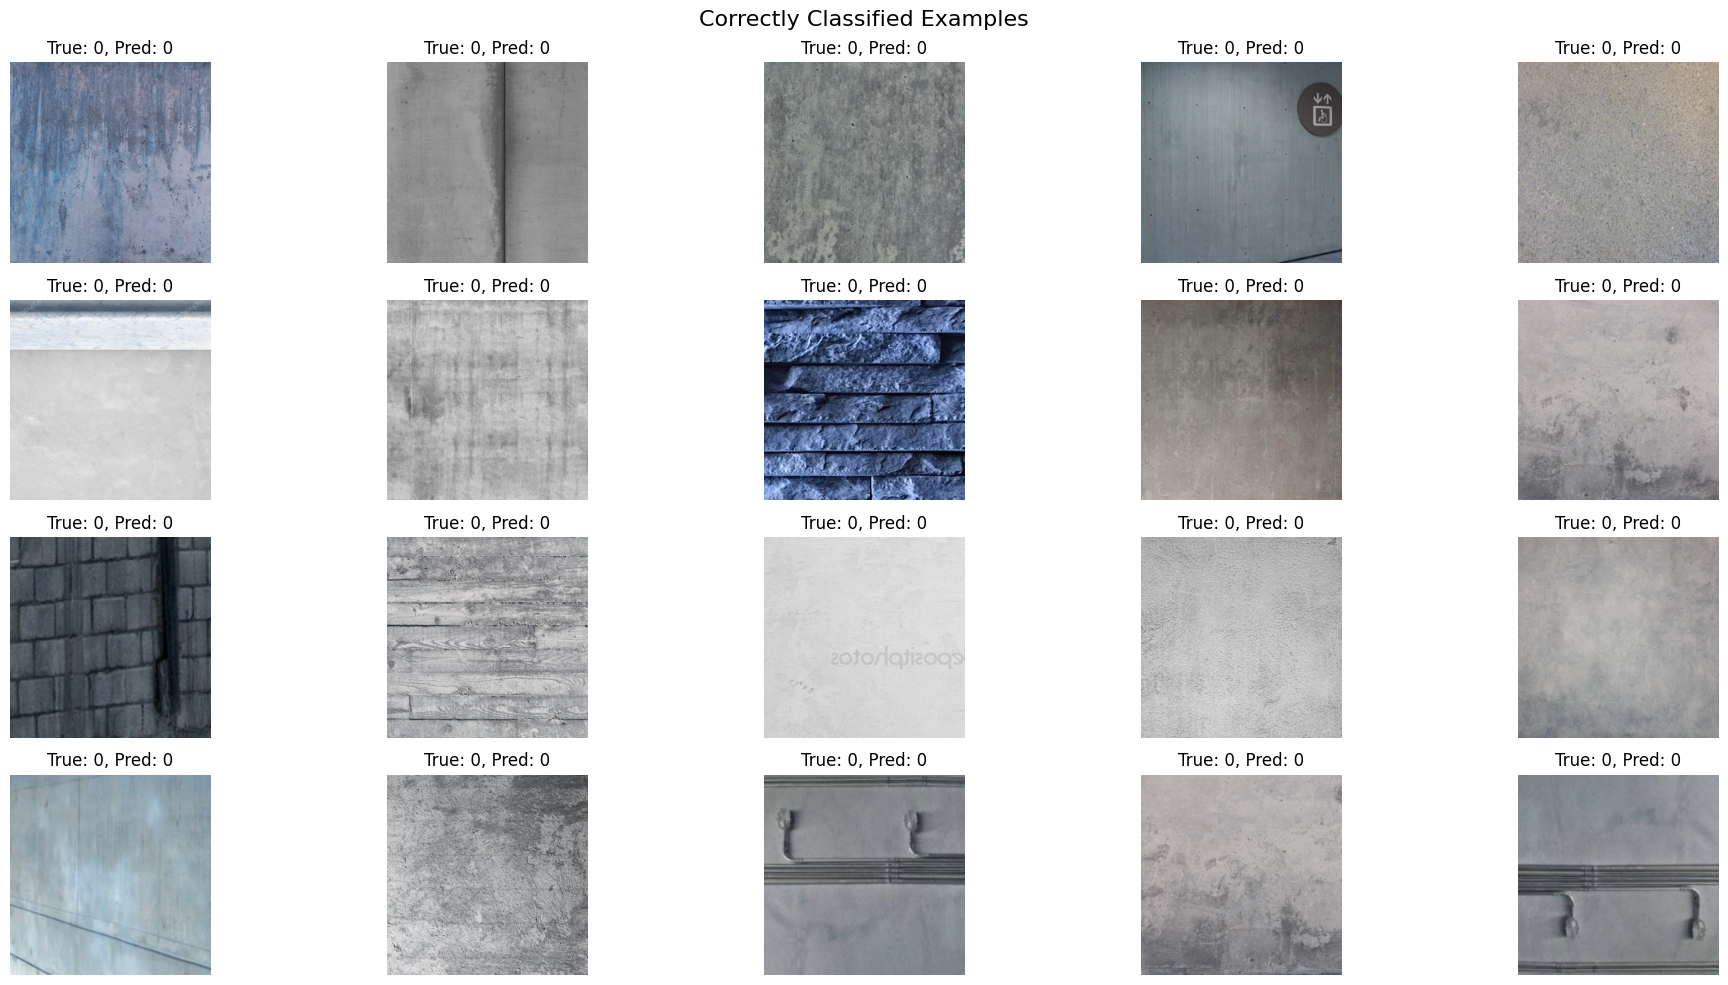

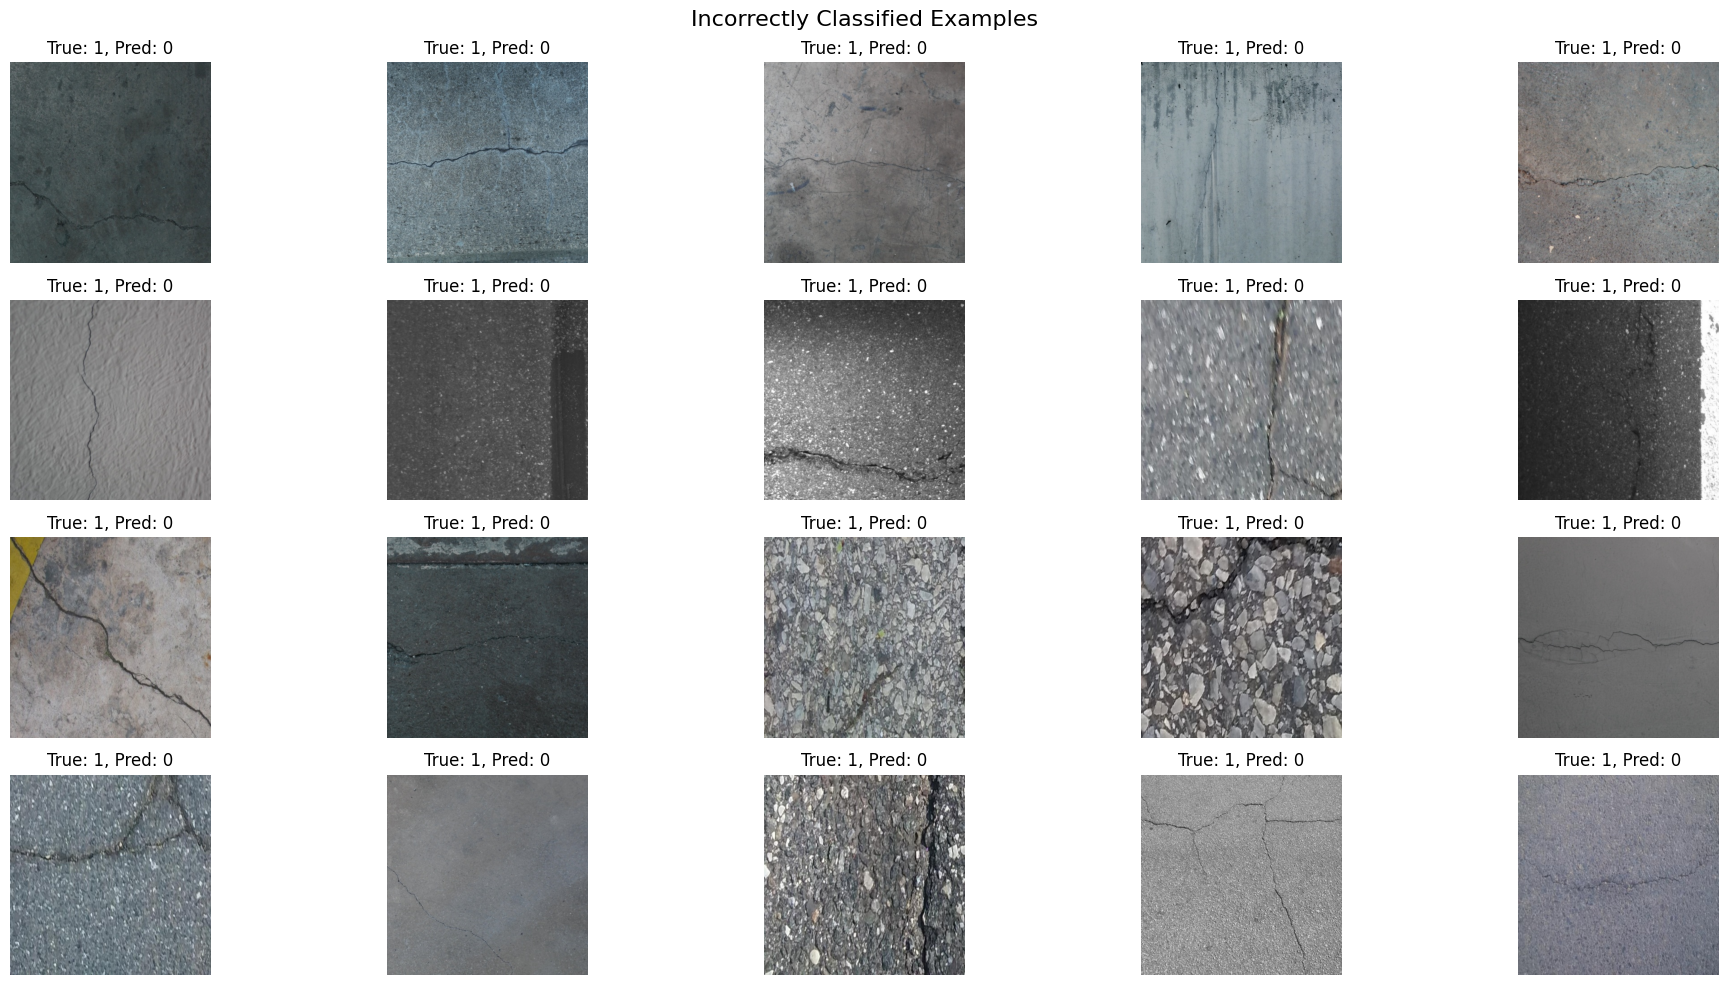

In [11]:
test_df = pd.DataFrame({
    "filepath": [],
    "label": []
})

images_directory = "./test/images"
masks_directory = "./test/masks"
labels = []
for img_name in os.listdir(images_directory):
    img_path = os.path.join(images_directory, img_name)
    
    mask_path = os.path.join(masks_directory, img_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    label = "1" if np.any(mask>0) else "0" 
    
    labels.append(label)
    test_df.loc[len(test_df)] = [img_path, label]
labels = np.array(labels)
# Load the model
model = model  # Load your trained model here

correctly_classified_images = []
incorrectly_classified_images = []

predi=test_df.copy()

for index, row in predi.iterrows():
    image_path = row['filepath']
    true_label = row['label']
    
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    target_size = (128, 128)
    image_resized = cv2.resize(image, target_size)
    image_normalized = image_resized / 255.0
    image_input = np.expand_dims(image_normalized, axis=0)
    
    predictions = model.predict(image_input, verbose=0)
    predicted_label = (predictions > 0.5).astype(int)[0][0]
    # print(predicted_label, type(true_label), predicted_label == int(true_label))
    
    if predicted_label == int(true_label):
        correctly_classified_images.append([image, true_label, predicted_label, image_path])
    else:
        incorrectly_classified_images.append([image, true_label, predicted_label, image_path])

random.seed(44)
 = random.sample(correctly_classified_images, min(20, len(correctly_classified_images)))
incorrectly_sample = random.sample(incorrectly_classified_images, min(20, len(incorrectly_classified_images)))

# Function to display images
def display_images(image_data, title):
    fig, axs = plt.subplots(4, 5, figsize=(20, 10))
    axs = axs.flatten()
    for i, (image, true_label, pred_label, image_path) in enumerate(image_data):
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img_rgb)
        axs[i].set_title(f"True: {true_label}, Pred: {pred_label}")
        axs[i].axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()correctly_sample

# Display the results
display_images(correctly_sample, "Correctly Classified Examples")
display_images(incorrectly_sample, "Incorrectly Classified Examples")

In [ ]:
#https://medium.com/@bijil.subhash/explainable-ai-saliency-maps-89098e230100

def find_layer_idx(model, layer_name):
    for idx, layer in enumerate(model.layers):
        if layer.name == layer_name:
            return idx
    return None

def apply_modifications(model):
    model = tf.keras.models.clone_model(model)
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Activation) and layer.activation == tf.keras.activations.linear:
            layer.activation = tf.keras.activations.linear
    return model


def display_explanation(image_data, title, model):
    n_samples = len(image_data)
    n_cols = 5
    n_rows = (n_samples + n_cols - 1) // n_cols  # Calculate number of rows needed
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
    axs = axs.flatten()  # Flatten to make indexing easier

    for i, (image, true_label, pred_label, image_path) in enumerate(image_data):
        # Read and preprocess the image
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (128, 128))
        img = np.array(img) / 255.0
        x = img_to_array(img)
        
        # Modify model for saliency map generation
        layer_idx = find_layer_idx(model, model.layers[-1].name)
        model.layers[-1].activation = tf.keras.activations.linear
        model = apply_modifications(model)
        score = BinaryScore(1.0)

        # Create Saliency object
        saliency = Saliency(model, clone=False)

        # Generate saliency map
        saliency_map = saliency(score, x, smooth_samples=100, smooth_noise=0.2)
        saliency_map = normalize(saliency_map)

        # Display the saliency map
        norm = Normalize(vmin=0, vmax=1)
        axs[i].imshow(saliency_map[0], cmap='RdBu_r', norm=norm)
        axs[i].set_title(f"True: {true_label}, Pred: {pred_label}")
        axs[i].axis('off')

    # Turn off unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Display the results
display_explanation(correctly_sample, "Correctly Classified Examples", model)
display_explanation(incorrectly_sample, "Incorrectly Classified Examples", model)




# img_path = "./test/images/noncrack_noncrack_concrete_wall_13_6.jpg.jpg"  
# # img_path = "./test/images/Rissbilder_for_Florian_9S6A2869_855_1425_2447_2662.jpg"  

 


# # swap last layer with linear layer  
# layer_idx = find_layer_idx(model, model.layers[-1].name)
# model.layers[-1].activation = tf.keras.activations.linear
# model = apply_modifications(model)

# from tf_keras_vis.utils.scores import CategoricalScore, BinaryScore
# score = BinaryScore(1.0)

# #Create Saliency object
# saliency = Saliency(model, clone=False)

# subplot_args = {
#    'nrows': 1,
#    'ncols': 1,
#    'figsize': (5, 4),
#    'subplot_kw': {'xticks': [], 'yticks': []}
# }

# # Generate saliency map
# saliency_map = saliency(score, x, smooth_samples=100, smooth_noise=0.2)
# saliency_map = normalize(saliency_map)

# f, ax = plt.subplots(**subplot_args)
# norm=Normalize(vmin=0, vmax=1)
# ax.imshow(saliency_map[0], cmap='RdBu_r', norm=norm)
# plt.tight_layout()
# plt.show()

# plt.imshow(np.array(x))

----------------
